In [24]:
import numpy as np
np.random.seed(123)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from changepoynt.algorithms.sst import SingularSpectrumTransformation
%matplotlib inline

In [25]:
# make synthetic step function
x0 = 1 * np.ones(1000) + np.random.rand(1000) * 1
x1 = 3 * np.ones(1000) + np.random.rand(1000) * 2
x2 = 5 * np.ones(1000) + np.random.rand(1000) * 1.5
x = np.hstack([x0, x1, x2])
x += np.random.rand(x.size)

In [26]:
# measure the timings and also plot them
def time_per_window_length(window_length, method, n_iter=10):

    # create the SST object
    sst = SingularSpectrumTransformation(window_length, method=method)

    # compute the scores and add to the timing
    measured_time = 0
    for idx in range(n_iter):
        start = time.time()
        sst.transform(x)
        measured_time += time.time()-start
    return measured_time / n_iter

def measure_time_and_plot():
    # measure the two methods for different timings
    win_lengths_candidates = np.logspace(1,2,5).astype(int)

    # trigger the jit compilation so comparison is fair
    SingularSpectrumTransformation(30, method='ika').transform(x)
    SingularSpectrumTransformation(30, method='svd').transform(x)
    SingularSpectrumTransformation(30, method='fbrsvd').transform(x)

    methods = []
    measured_times = []
    window_lengths = []

    for method in ("svd", "ika", "fbrsvd"):
        for wl in win_lengths_candidates:
            for j in range(10):
                measured_times.append(time_per_window_length(wl, method=method, n_iter=1))
                methods.append(method)
                window_lengths.append(wl)

    df = pd.DataFrame({"time[s]": measured_times, "method":methods, "window length":window_lengths})
    sns.barplot(x="window length", y="time[s]", hue="method", data=df)

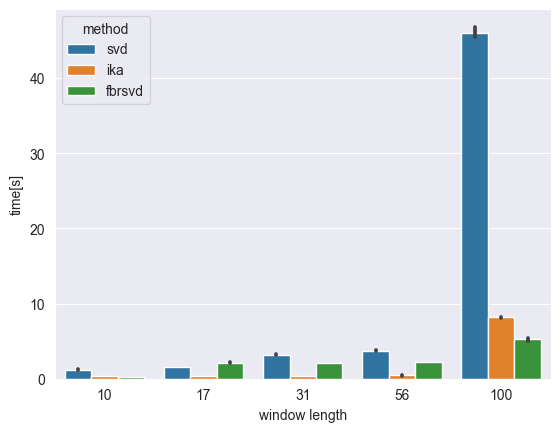

In [15]:
measure_time_and_plot()

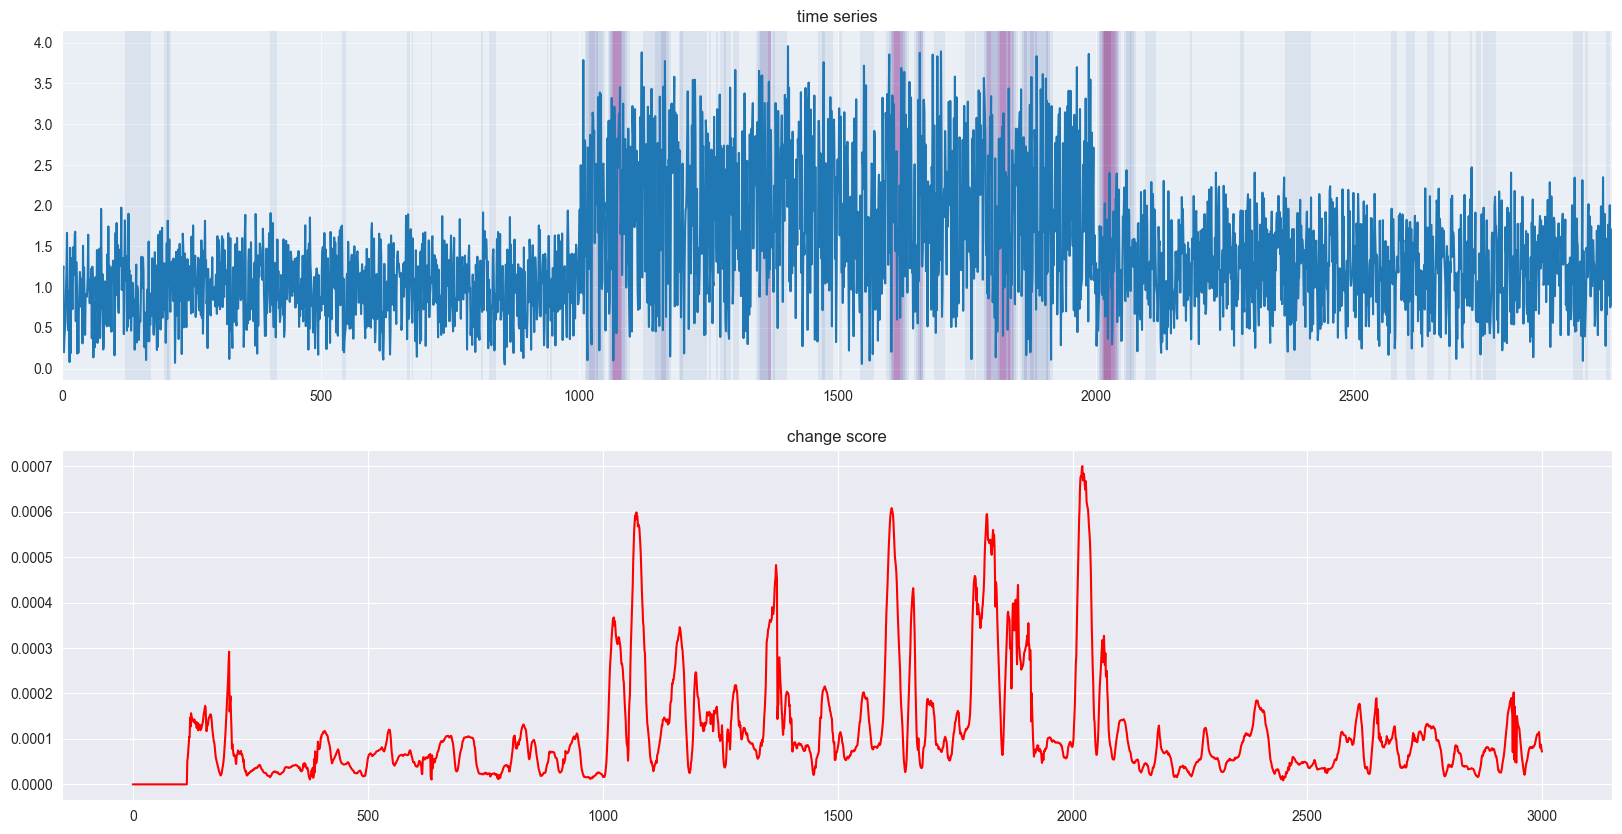

In [60]:
# some plotting utilities
def plot_data_and_score(raw_data, score):
    f, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(raw_data); ax[0].set_title("time series")
    ax[1].plot(score,"r"); ax[1].set_title("change score")
    x_grid, y_grid = np.meshgrid(np.arange(len(score)),np.linspace(*ax[0].get_ylim()))
    z_grid = (score/np.max(score))[x_grid]
    ax[0].contourf(x_grid, y_grid, z_grid,alpha=0.5, cmap="BuPu")

# compute change score using ika sst
score = SingularSpectrumTransformation(window_length=50, rank=5, method="ika").transform(x)
plot_data_and_score(x,score)

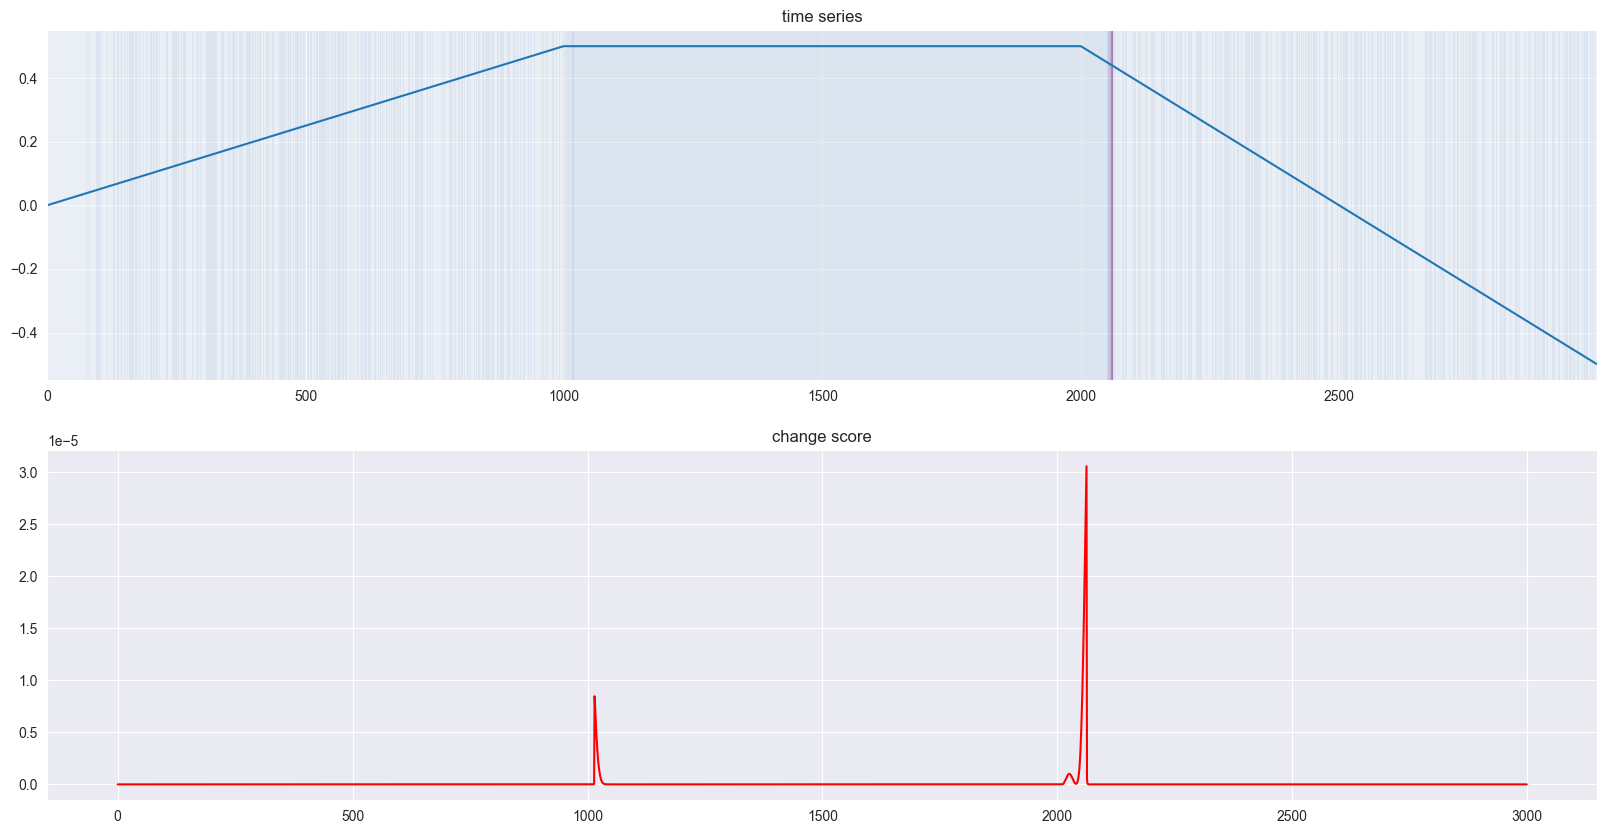

In [61]:
length = 1000
x2 = np.hstack([np.linspace(0, 0.5, num=length), 0.5 * np.ones(length) , np.linspace(0.5, -0.5, num=length)])
# compute change score using sst
score = SingularSpectrumTransformation(window_length=30, rank=5, method="svd").transform(x2)
plot_data_and_score(x2,score)

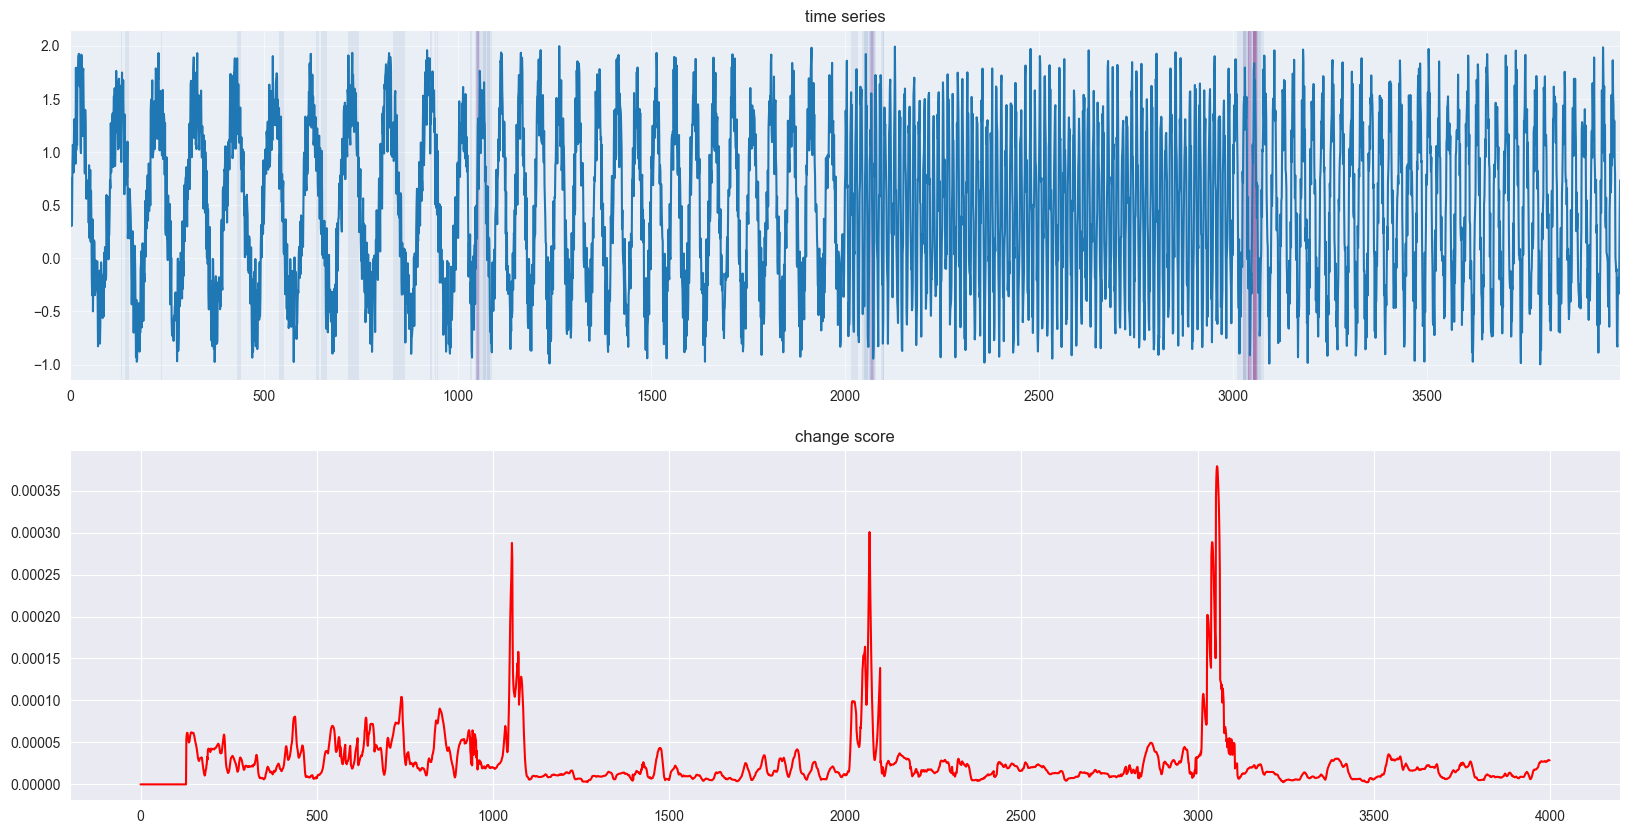

In [62]:
# synthetic (frequency change)
x0 = np.sin(2*np.pi*1*np.linspace(0,10,1000))
x1 = np.sin(2*np.pi*2*np.linspace(0,10,1000))
x2 = np.sin(2*np.pi*8*np.linspace(0,10,1000))
x3 = np.sin(2*np.pi*4*np.linspace(0,10,1000))
x = np.hstack([x0, x1, x2, x3])
x += np.random.rand(x.size)

# compute change score using sst
score = SingularSpectrumTransformation(window_length=60, lag=10, rank=5).transform(x)
plot_data_and_score(x,score)

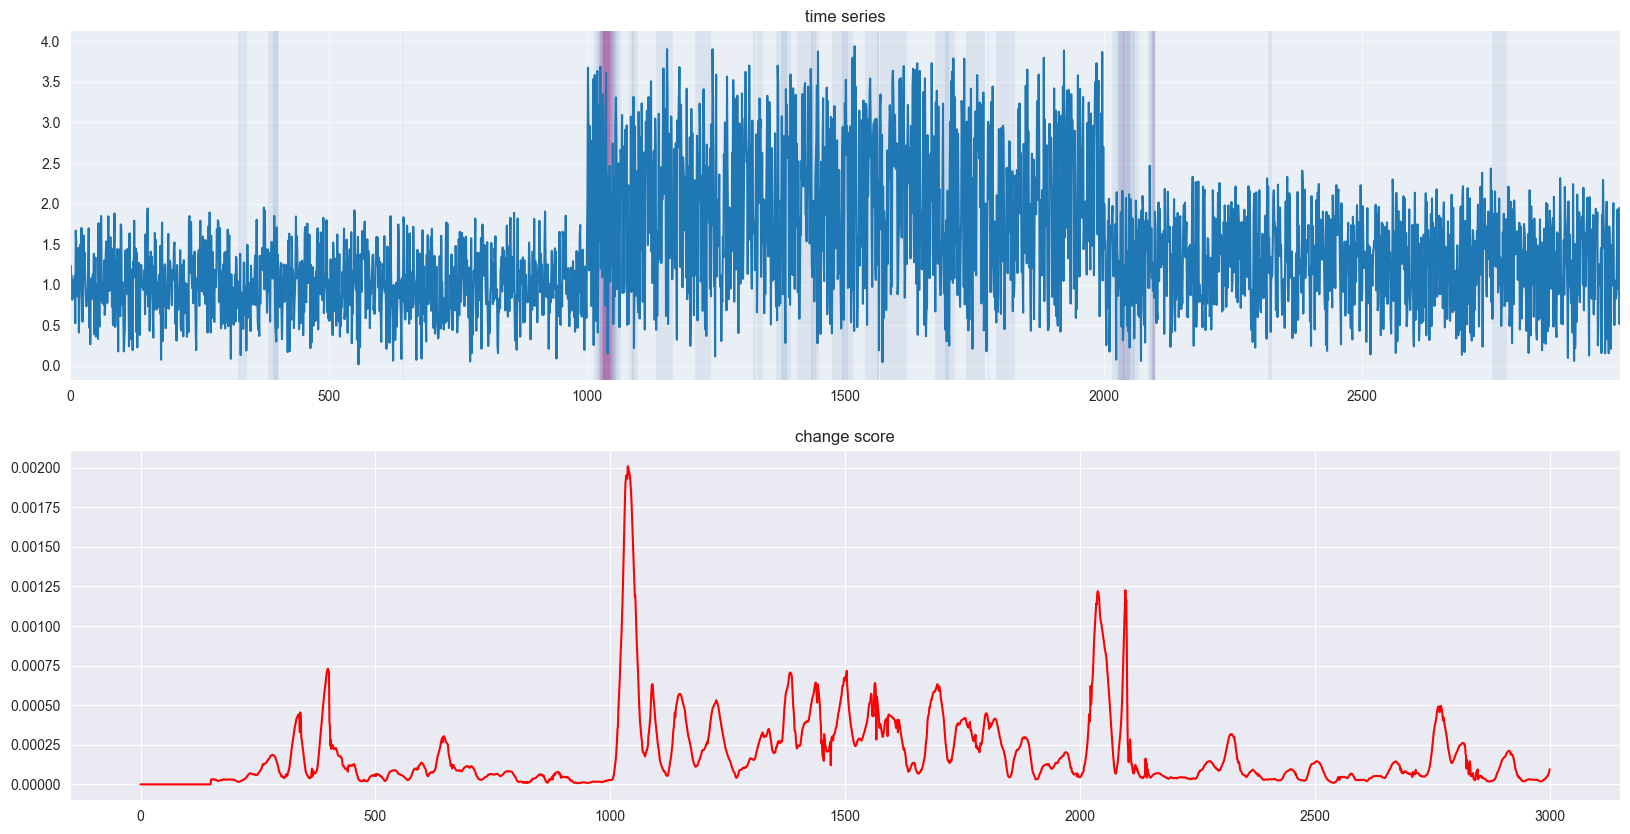

In [63]:
# make synthetic variance noise change
x0 = np.random.rand(1000) * 1
x1 = np.random.rand(1000) * 3
x2 = np.random.rand(1000) * 1.5
x = np.hstack([x0, x1, x2])
x += np.random.rand(x.size)

# compute change score using sst
score = SingularSpectrumTransformation(window_length=60, lag=30, rank=5).transform(x)
plot_data_and_score(x,score)